# Vision transformer


## Import libraries

In [1]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from attention_mnist_utils import (
    image_to_patches,
    train,
    MLP,
    evaluate_classification,
)
from IPython.display import clear_output

## Setting some parameters

In [3]:
device = torch.device("mps")
print("Device:", device)

Device: mps


## Downloading MNIST from torchvision

In [9]:
# set the preprocess operations to be performed on train/val/test samples
preprocessing_transformation = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.MNIST(
    root="./data/torchvision/MNIST/training",
    train=True,
    download=True,
    transform=preprocessing_transformation,
)
train_set, test_set = torch.utils.data.random_split(train_dataset, [40000, 20000])

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=True)

In [10]:
len(train_loader.dataset), len(test_loader.dataset)

(40000, 20000)

Let's check that we have the correct number of samples in our dataloader

Let's see how many batches we have in the dataloader

In [11]:
len(train_loader), len(test_loader)

(1250, 625)

Let's pick four example images

In [12]:
n_images = 4
examples_imgs = torch.stack([test_set[idx][0] for idx in range(n_images)], dim=0)

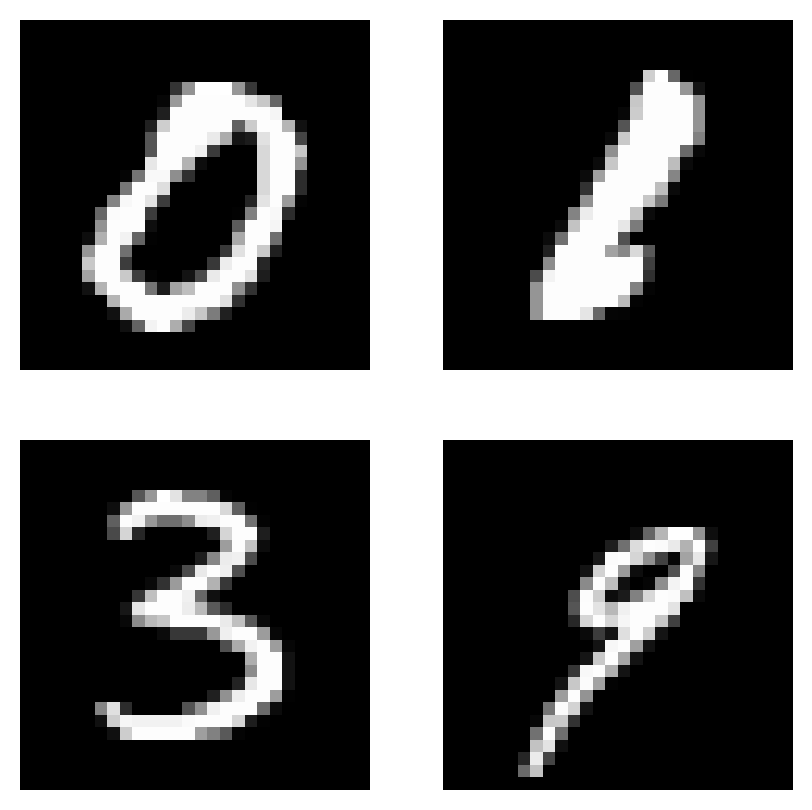

In [13]:
plt.figure(figsize=(5, 5))
for i in range(n_images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(examples_imgs[i, 0], cmap="gray")
    plt.axis("off")
plt.show()

## Visualizing `image_to_patches` function

We first transform the four examples images to patches.

In [14]:
# image size in one dimension (whole image is of shape (image_size , image_size)
image_size = 28

# patch size in one dimension (whole patch is of shape (patch_size , patch_size)
patch_size = 4

# total number of patches
num_patches = int((image_size / patch_size) ** 2)

In [15]:
img_patches = image_to_patches(examples_imgs, patch_size=patch_size)
img_patches.shape

torch.Size([4, 49, 16])

This shape corresponds to 4 images with 49 (7x7) patches, each consisting of 16 pixels (4x4). For the model, this shape is fine, but for visualizing the patched image we need to reshape it.

In [16]:
num_patch_per_dim = int(np.sqrt(num_patches))

In [17]:
image = img_patches[1].reshape(7, 7, 4, 4)

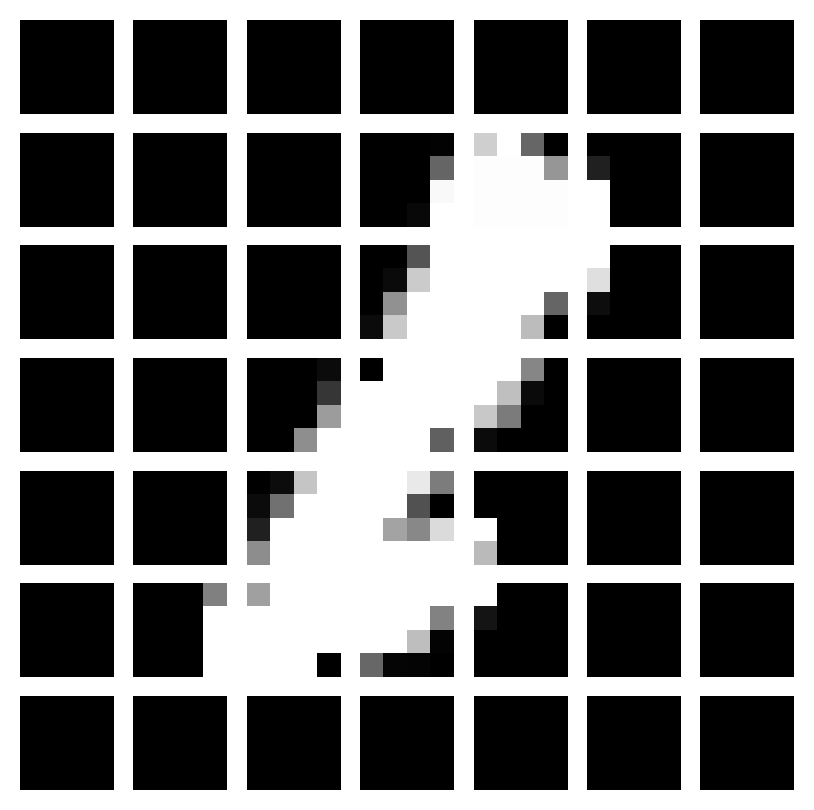

In [18]:
plt.figure(figsize=(5, 5))
k = 0
for i in range(num_patch_per_dim):
    for j in range(num_patch_per_dim):
        k += 1

        plt.subplot(num_patch_per_dim, num_patch_per_dim, k)
        plt.imshow(image[i, j], cmap="gray")
        plt.axis("off")

## VisionTransformer class

In [19]:
import torch
import torch.nn.functional as F


class ScaledDotProductAttention(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.scale = 1.0 / (d_model**0.5)

        # Define linear layers for queries, keys, and values
        self.query_linear = nn.Linear(out_features=d_model, in_features=d_model)
        self.key_linear = nn.Linear(out_features=d_model, in_features=d_model)
        self.value_linear = nn.Linear(out_features=d_model, in_features=d_model)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, keys, queries, values):
        """
        Args:
            keys: tensor of shape (batch_size, d_seq, d_model)
            queries: tensor of shape (batch_size, d_seq, d_model)
            values: tensor of shape (batch_size, d_seq, d_model)

        Returns:
            context: tensor of shape (batch_size, d_seq, d_model)
        """
        # Project x to query, key, and value
        query = self.query_linear(queries)  # shape: (batch_size, d_seq, d_model)
        key = self.key_linear(keys)  # shape: (batch_size, d_seq, d_model)
        value = self.value_linear(values)  # shape: (batch_size, d_seq, d_model)

        # Compute scaled dot product
        scaled_dot_product = self.scale * torch.bmm(query, key.transpose(1, 2))

        # Compute attention weights
        attn_weights = self.softmax(scaled_dot_product)
        attention = torch.bmm(attn_weights, value)

        return attention

In [20]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, d_model):
        """
        Inputs:
            d_model - Feature dimension
        """
        super().__init__()

        self.self_attention = ScaledDotProductAttention(d_model)
        self.mlp = MLP([d_model, d_model, d_model])

    def forward(self, x):

        attention = self.self_attention(x, x, x)

        # Residual attention update
        x = x + attention

        # Residual MLP update
        x = x + self.mlp(x)
        return x

In [21]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        d_model,
        num_layers,
        num_classes,
        patch_size,
    ):
        """
        Inputs:
            d_model - Dimensionality of the input feature vectors to the Transformer
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension

        """
        super().__init__()

        self.patch_size = patch_size

        self.linear_in = nn.Linear(patch_size**2, d_model)

        self.transformer = nn.Sequential(
            *(SelfAttentionBlock(d_model) for _ in range(num_layers))
        )
        self.linear_out = nn.Linear(d_model, num_classes)

        # Class token
        self.class_token = nn.Parameter(torch.randn(1, 1, d_model))

    def forward(self, x):

        # Image to patches
        x = image_to_patches(x, self.patch_size)
        
        # Embed patches
        x = self.linear_in(x)  # x.shape ---> n_samples, n_patches, d_model

        n_samples, _, _ = x.shape

        # Concatenate the class token with the patch features
        cls_token = self.class_token.repeat(n_samples, 1, 1)
        x = torch.cat(
            [cls_token, x], dim=1
        )  # x.shape ---> (n_samples,n_patches+1, d_model)

        # Transformer update
        x = self.transformer(x)

        # Perform classification prediction
        class_features = x[:, 0, :]

        class_prediction = self.linear_out(class_features)
        return class_prediction

## Initializing the model

We use the following hyperparameters for our model.

In [22]:
d_model = 64
num_layers = 5
num_classes = 10

In [23]:
model = VisionTransformer(
    d_model=d_model,
    num_layers=num_layers,
    patch_size=patch_size,
    num_classes=num_classes,
).to(device)

In [24]:
def count_parameters(self):
    """
    Counts the number of trainable parameters.

    """
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [25]:
count_parameters(model)

105802

## Training

In [26]:
NUM_EPOCHS = 1000

In [27]:
# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [28]:
len(train_loader)

1250

In [35]:
# losses = []
# for epoch in range(1, NUM_EPOCHS + 1):
#     loss = train(model, train_loader, optimizer, loss_fn, device)
#     losses.append(loss)
# torch.save(model, "transformer.pt")
# torch.save(losses, "losses.pt")

In [29]:
model = torch.load("transformer.pt", weights_only=False)
model.eval()
losses = torch.load("losses.pt", weights_only=False);

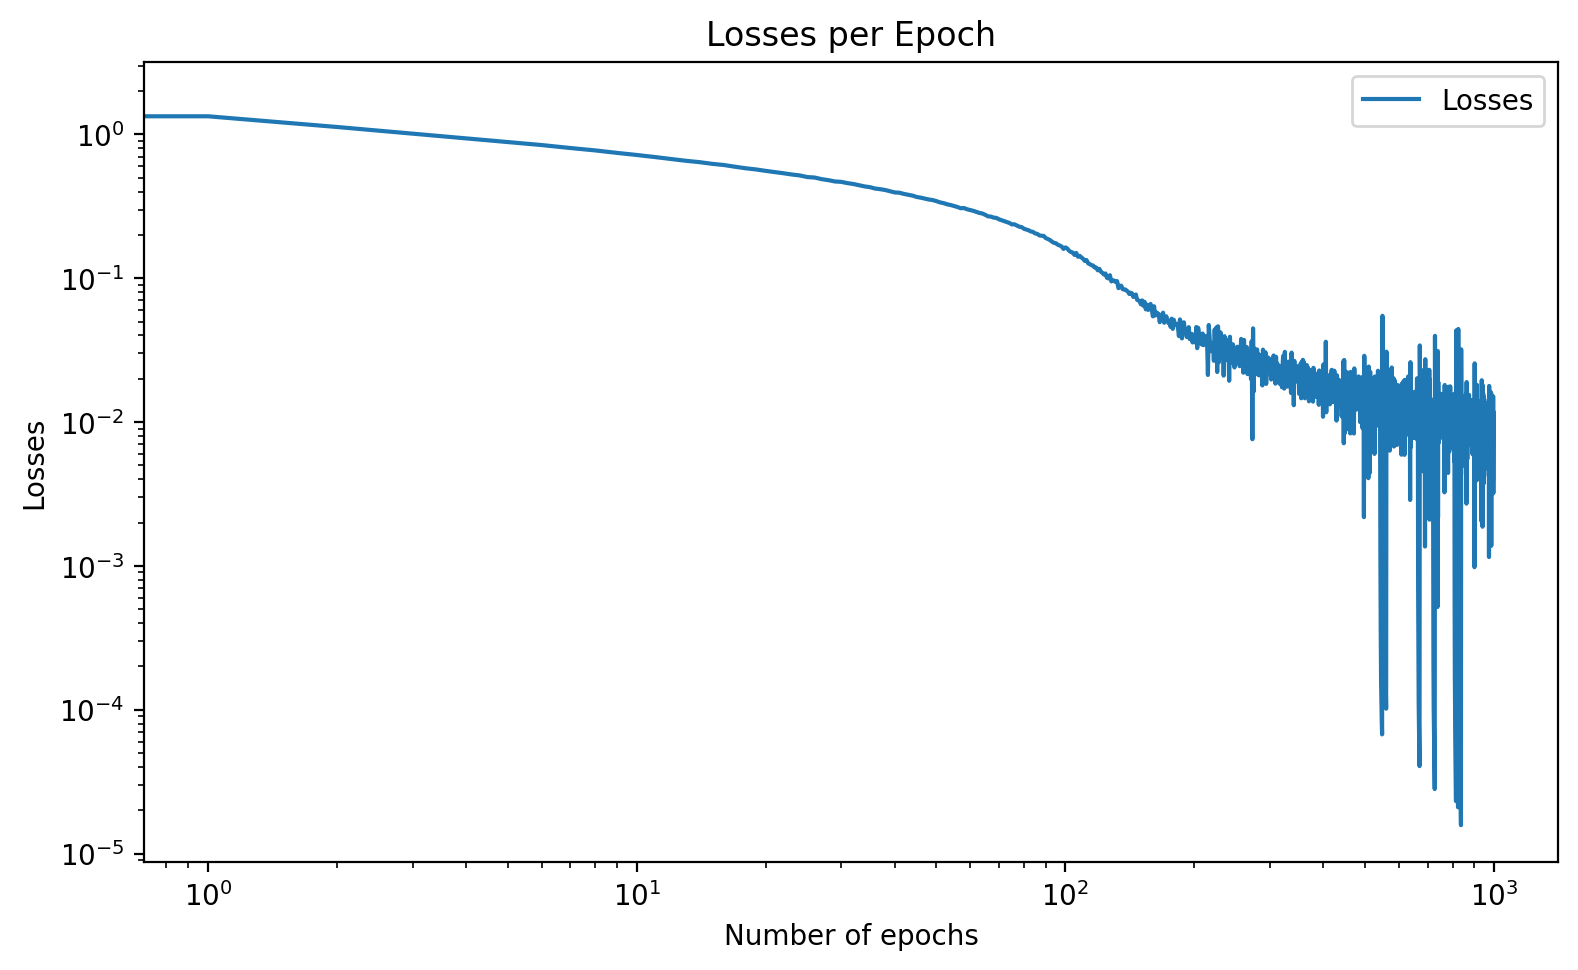

In [30]:
plt.figure(figsize=(8, 5))
plt.title("Losses per Epoch")
plt.plot(losses, label="Losses")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Losses")
plt.xlabel("Number of epochs")
plt.legend()
plt.savefig("losses_transformer.png", dpi=600)
plt.tight_layout()
plt.show()

In [32]:
def my_evaluate_classification(model: nn.Module, criterion: nn.modules.loss._Loss, test_loader: data.DataLoader, device: str):

    """
        Evaluates a classification model by computing loss and classification accuracy on a test set.

        Parameters:
        -----------
        model : pytorch model.
        test_loader : pytorch Dataloader containing the test data.
        criterion: Loss function.

    """

    model.eval()

    val_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(test_loader)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)

    return val_loss, accuracy.item()

In [34]:
my_evaluate_classification(model, loss_fn, test_loader, device)

(0.4591513663625017, 94.71499633789062)

## Picking one test sample and running it through the first attention block

In [44]:
test_sample_index = (test_set.dataset.targets == 3).nonzero(as_tuple=True)[0][10].item()
test_sample_index

98

In [45]:
# pull out one test sample
image = test_set.dataset[test_sample_index][0][0].to(device)

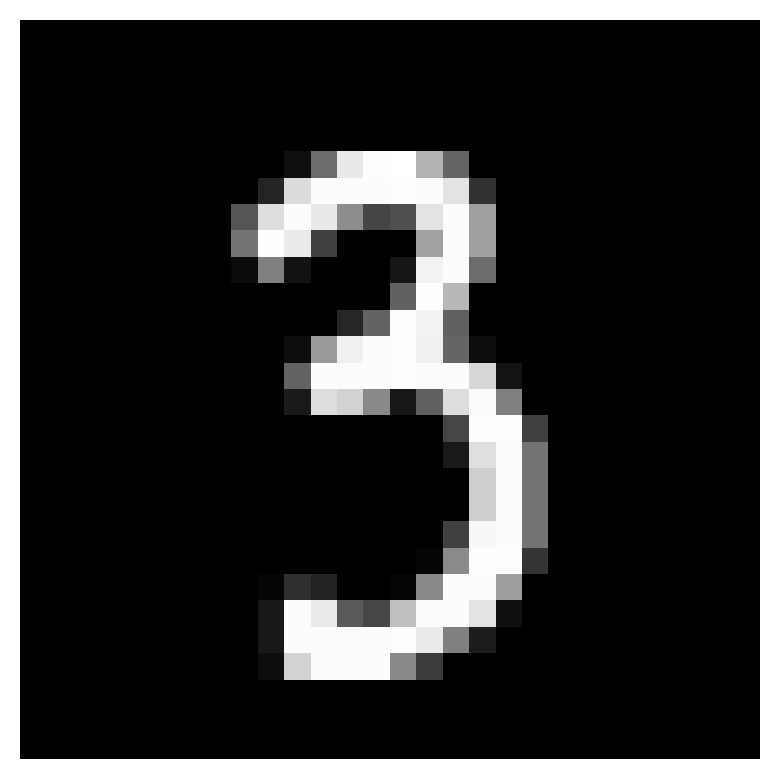

In [46]:
plt.imshow(image.cpu(), cmap="gray")
plt.axis("off")
plt.show()

We can compute the attention by embedding the data and the manually computing the map.

In [47]:
image.shape

torch.Size([28, 28])

In [48]:
x = image_to_patches(image.reshape(1, 1, 28, 28), model.patch_size)

x_embedded = model.linear_in(x)

class_token = model.class_token.repeat(1, 1, 1)

x_cat = torch.cat(
    [class_token, x_embedded], dim=1
)  # shape should be (num_patches+1, n_samples, embed_dim)

first_self_attention = model.transformer[0].self_attention
queries = first_self_attention.query_linear(x_cat)
keys = first_self_attention.key_linear(x_cat)
weights = first_self_attention.softmax(first_self_attention.scale * torch.bmm(queries, keys.transpose(1, 2)))

We can interpolate the map back to 28x28 pixels.

In [49]:
attn_heatmap_resized = F.interpolate(
    weights[0, 0, 1:].reshape(1, 1, 7, 7),
    [image_size, image_size],
    mode="bilinear",
).view(28, 28)

In [50]:
attn_heatmap_resized.shape

torch.Size([28, 28])

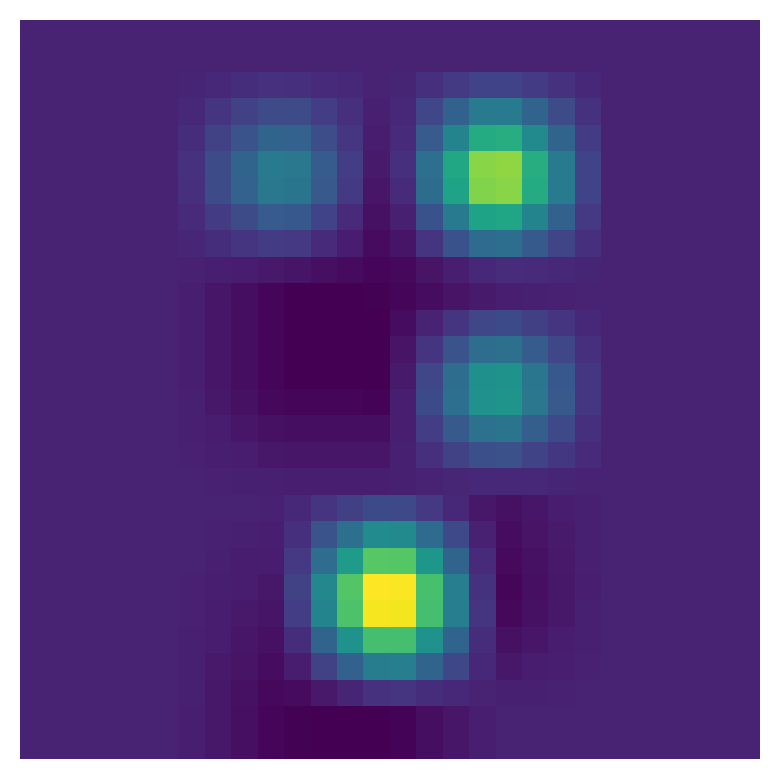

In [51]:
plt.imshow(attn_heatmap_resized.cpu().detach().numpy())
plt.axis("off")
plt.show()

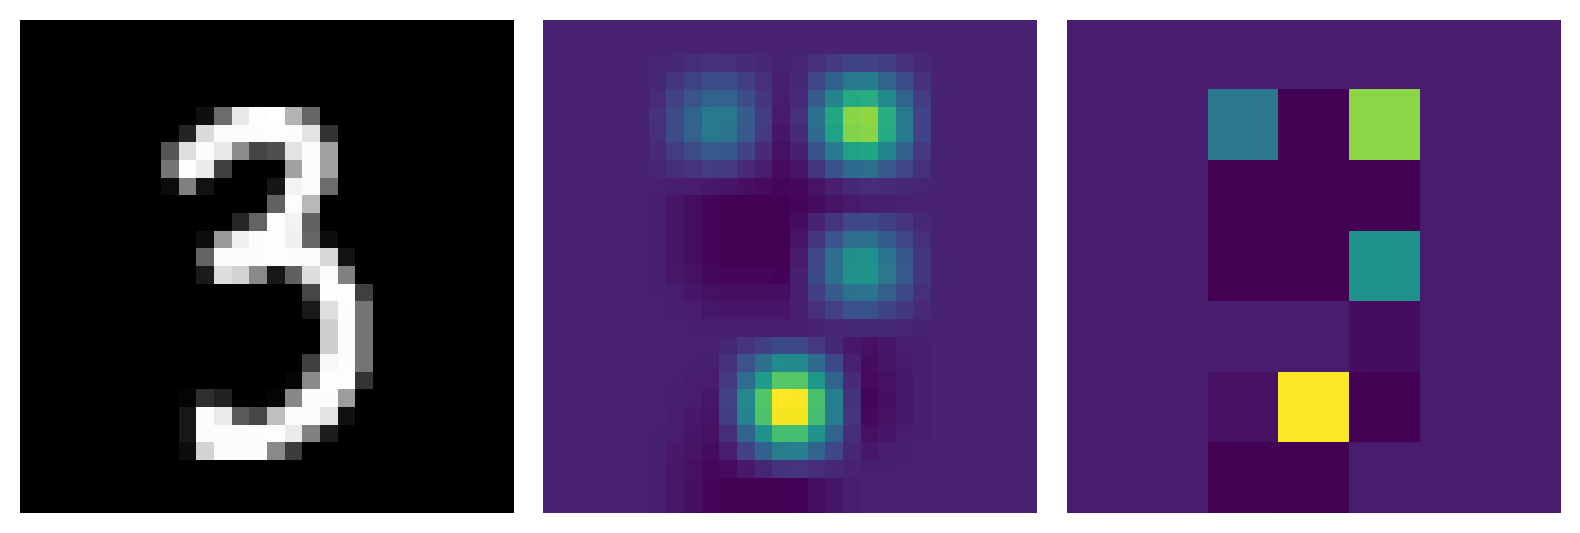

In [52]:
plt.figure(figsize=(8,5))
plt.subplot(1, 3, 1)
plt.imshow(image.cpu(), cmap="gray")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(attn_heatmap_resized.cpu().detach().numpy())
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(weights[0, 0, 1:].cpu().detach().numpy().reshape(7, 7))
plt.axis('off')
plt.savefig("attention_map.png", dpi=600)
plt.tight_layout()
plt.show()